# Multilayer Perceptron for Financial Forecasting

A comprehensive analysis using polynomial detrending, seasonal differencing, and neural networks for time series prediction.

In [130]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

excel_file = 'M3C.xls'
sheet_name = "M3Month"
category = "FINANCE"

In [131]:
data = pd.read_excel(excel_file, sheet_name=sheet_name)
print("Data loaded")

Data loaded


In [132]:
# Start from the 7th column (index 6) to the end
category_data = data[data['Category'].str.strip() == category]
series = category_data.iloc[0, 6:].dropna().astype(float)  # Changed from iloc[0] to iloc[1] for second series

2. Here we take the first monthly timeseries in the category of finance. We plot it alongside its 2nd degree polynomial trend.

Selected series length: 143 time points


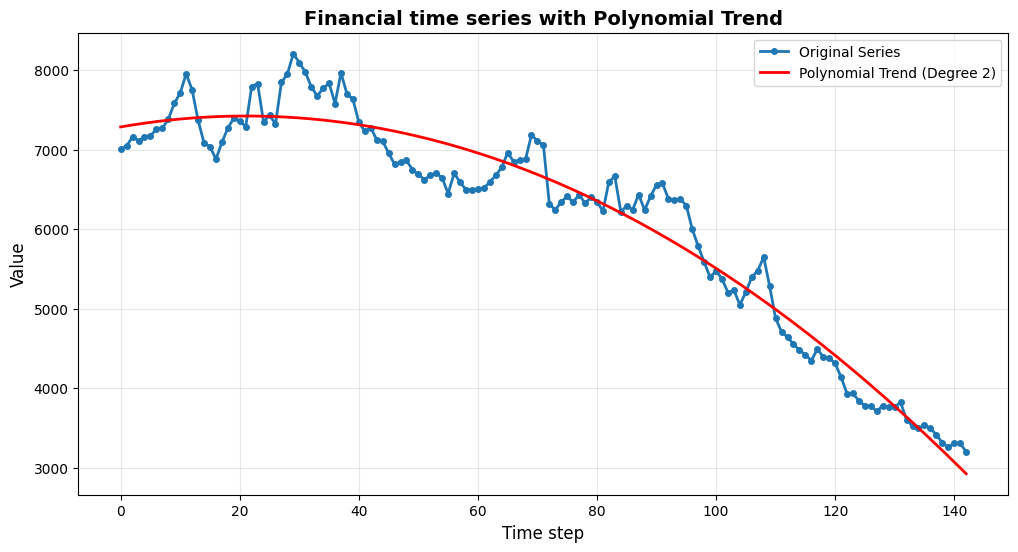

In [133]:
 # One times series with polynomial trend
print(f"Selected series length: {len(series)} time points")
poly = PolynomialFeatures(degree=2)
X = np.arange(len(series)).reshape(-1, 1)
y = series.values

x_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(x_poly, y)
poly_trend = poly_model.predict(x_poly)

plt.figure(figsize=(12, 6))
plt.plot(series.values, marker='o', linewidth=2, markersize=4, label='Original Series')
plt.plot(poly_trend, color='red', linewidth=2, label='Polynomial Trend (Degree 2)')
plt.title("Financial time series with Polynomial Trend", fontsize=14, fontweight='bold')
plt.legend()
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

3. Next up is de-trending and de-seasonalizing the timeseries to prepare the input for the MLP

Training data length: 119
X_train shape: (107, 12)
y_train shape: (107,)
Validation data length: 12
Mean: -0.000000, Std: 1.000000

X_train shape: (107, 12)
y_train shape: (107,)
Validation data length: 12
Mean: -0.000000, Std: 1.000000


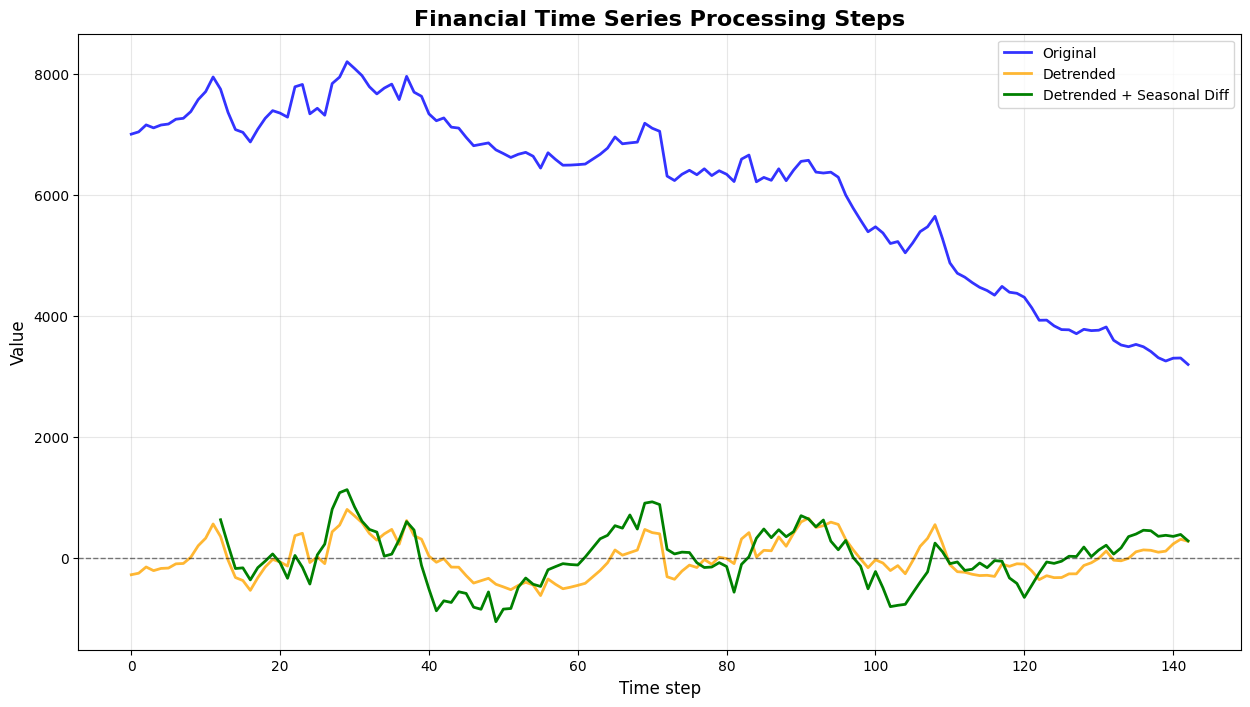

In [134]:
# De-trended and de-seasonal differenced series

de_trended = y - poly_trend

months_in_year = 12
seasonal_diff = list()
for i in range(months_in_year, len(de_trended)):
    value = de_trended[i] - de_trended[i - months_in_year]
    seasonal_diff.append(value)

# Combined plot
plt.figure(figsize=(15, 8))
plt.plot(range(len(y)), y, 'b-', linewidth=2, label='Original', alpha=0.8)
plt.plot(range(len(de_trended)), de_trended, 'orange', linewidth=2, label='Detrended', alpha=0.8)
plt.plot(range(months_in_year, len(de_trended)), seasonal_diff, 'green', linewidth=2, label='Detrended + Seasonal Diff')

plt.title("Financial Time Series Processing Steps", fontsize=16, fontweight='bold')
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.legend()
# Normalize the seasonal_diff data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
seasonal_diff_scaled = scaler.fit_transform(np.array(seasonal_diff).reshape(-1, 1)).flatten()

# Split normalized data: hold out last 12 months for validation
validation_data = seasonal_diff_scaled[-12:]  # Last 12 actual values
training_data = seasonal_diff_scaled[:-12]    # Everything except last 12
# Normalize the seasonal_diff data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
seasonal_diff_scaled = scaler.fit_transform(np.array(seasonal_diff).reshape(-1, 1)).flatten()

# Split normalized data: hold out last 12 months for validation
validation_data = seasonal_diff_scaled[-12:]  # Last 12 actual values
training_data = seasonal_diff_scaled[:-12]    # Everything except last 12

# Function to create sequences for time series
def create_sequences(data, lookback=12):
    """
    Create sequences from time series data
    
    Parameters:
    - data: 1D array of time series values
    - lookback: number of previous time steps to use as input
    
    Returns:
    - X: array of shape (n_samples, lookback) - input sequences
    - y: array of shape (n_samples,) - target values
    """
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

# Create sequences from training data only
X_train, y_train = create_sequences(training_data, lookback=12)

print(f"Training data length: {len(training_data)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Validation data length: {len(validation_data)}")
print(f"Mean: {seasonal_diff_scaled.mean():.6f}, Std: {seasonal_diff_scaled.std():.6f}")



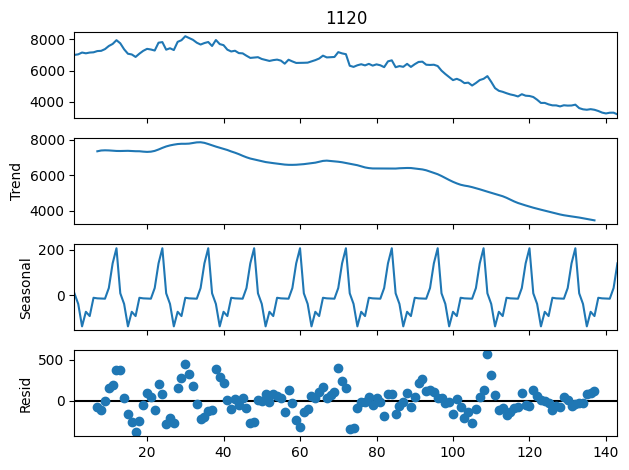

In [135]:
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(series, model='additive', period=12).plot()

In [136]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        # Better weight initialization (He initialization for tanh)
        self.weight_hidden = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.weight_output = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.bias_output = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.losses = []

    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x) ** 2

    def forward(self, X):
        # Hidden layer with tanh activation
        self.hidden_input = np.dot(X, self.weight_hidden) + self.bias_hidden
        self.hidden_output = self.tanh(self.hidden_input)
        
        # Output layer with LINEAR activation (no activation for regression)
        self.final_input = np.dot(self.hidden_output, self.weight_output) + self.bias_output
        self.final_output = self.final_input  # Linear output for regression
        
        return self.final_output
    
    def backward(self, X, y, output):
        m = X.shape[0]  # Number of samples
        
        # Reshape y to match output shape
        y = y.reshape(-1, 1)
        
        # Output layer gradient (linear activation, so derivative = 1)
        output_error = output - y  # Shape: (m, 1)
        
        # Hidden layer gradient
        hidden_error = np.dot(output_error, self.weight_output.T) * self.tanh_derivative(self.hidden_input)
        
        # Update weights and biases
        self.weight_output -= self.learning_rate * np.dot(self.hidden_output.T, output_error) / m
        self.bias_output -= self.learning_rate * np.sum(output_error, axis=0, keepdims=True) / m
        self.weight_hidden -= self.learning_rate * np.dot(X.T, hidden_error) / m
        self.bias_hidden -= self.learning_rate * np.sum(hidden_error, axis=0, keepdims=True) / m

    def train(self, X, y, epochs):
        # Use tqdm for progress bar
        for epoch in tqdm(range(epochs), desc="Training progress"):
            # Forward pass
            output = self.forward(X)
            
            # Backward pass
            self.backward(X, y, output)
            
            # Calculate MSE loss
            loss = np.mean((output - y.reshape(-1, 1)) ** 2)
            self.losses.append(loss)

            # Optionally show intermediate loss info inside tqdm
            tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss (MSE): {loss:.6f}") if (epoch + 1) % 100000 == 0 else None

        tqdm.write(f"Training completed! Final loss: {loss:.6f}")
        
    def predict(self, X):
        """Make predictions on new data"""
        output = self.forward(X)
        return output.flatten()
    


In [137]:
model = MLP(input_size=12, hidden_size=50, output_size=1, learning_rate=0.001)
model.train(X_train, y_train, epochs=1000000)
# Make predictions using TensorFlow model
def forecast_multiple_steps_tf(model, last_sequence, n_steps=12):
    """
    Forecast multiple future time steps using a TensorFlow model.
    
    Parameters:
    - model: Trained TensorFlow model
    - last_sequence: Last input sequence from training data
    - n_steps: Number of future steps to forecast
    
    Returns:
    - predictions: List of predicted values for the next n_steps
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        current_sequence_reshaped = current_sequence.reshape((1, -1))
        next_value = model.predict(current_sequence_reshaped)
        predictions.append(next_value[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_value  # Append the predicted value
    
    return np.array(predictions)  



Training progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Training progress:  10%|█         | 101015/1000000 [00:16<01:50, 8099.43it/s]

Epoch 100000/1000000, Loss (MSE): 0.036535


Training progress:  20%|██        | 200192/1000000 [00:35<03:45, 3547.92it/s]

Epoch 200000/1000000, Loss (MSE): 0.011893


Training progress:  30%|███       | 300715/1000000 [01:06<02:20, 4964.11it/s]

Epoch 300000/1000000, Loss (MSE): 0.004627


Training progress:  40%|████      | 400929/1000000 [01:29<02:06, 4734.87it/s]

Epoch 400000/1000000, Loss (MSE): 0.001965


Training progress:  50%|█████     | 500771/1000000 [01:54<01:26, 5739.53it/s]

Epoch 500000/1000000, Loss (MSE): 0.000856


Training progress:  60%|██████    | 600812/1000000 [02:18<01:03, 6300.49it/s]

Epoch 600000/1000000, Loss (MSE): 0.000377


Training progress:  70%|███████   | 700889/1000000 [02:42<01:00, 4953.01it/s]

Epoch 700000/1000000, Loss (MSE): 0.000169


Training progress:  80%|████████  | 800808/1000000 [02:59<00:34, 5842.46it/s]

Epoch 800000/1000000, Loss (MSE): 0.000078


Training progress:  90%|█████████ | 900517/1000000 [03:17<00:17, 5710.68it/s]

Epoch 900000/1000000, Loss (MSE): 0.000037


Training progress: 100%|██████████| 1000000/1000000 [03:35<00:00, 4642.88it/s]

Epoch 1000000/1000000, Loss (MSE): 0.000018
Training completed! Final loss: 0.000018


In [138]:
predictions_scaled = model.predict(X_train)
print("Predictions (scaled):", predictions_scaled)



Predictions (scaled): [-0.98100058  0.08162079  0.4769367   1.75175673  2.35597354  2.46306268
  1.83857621  1.31526909  1.0121898   0.91756484  0.03738813  0.11125111
  0.63523971  1.2989074   0.99037452 -0.29923663 -1.16314701 -1.95558568
 -1.59486646 -1.65259296 -1.26294559 -1.3229847  -1.82547343 -1.89988659
 -1.26901068 -2.35623123 -1.89811888 -1.87093848 -1.09828027 -0.76027965
 -0.98907354 -1.07009353 -0.45882878 -0.3441141  -0.2351323  -0.26935406
 -0.28566159  0.00695379  0.33155796  0.67925596  0.78124243  1.16083961
  1.05861013  1.53586669  1.05000365  1.95620194  2.004831    1.92801855
  0.29075964  0.11829636  0.18449239  0.16775889 -0.20287234 -0.37591524
 -0.35843291 -0.20053049 -0.34132129 -1.27681341 -0.26120791  0.0134916
  0.69102518  1.02833175  0.71332151  1.00041416  0.74443741  0.92935586
  1.51760284  1.39804746  1.11008177  1.35762548  0.57900773  0.27181313
  0.60918008 -0.00717278 -0.32882087 -1.15449262 -0.52620625 -1.11659354
 -1.80611535 -1.75786392 -1.71

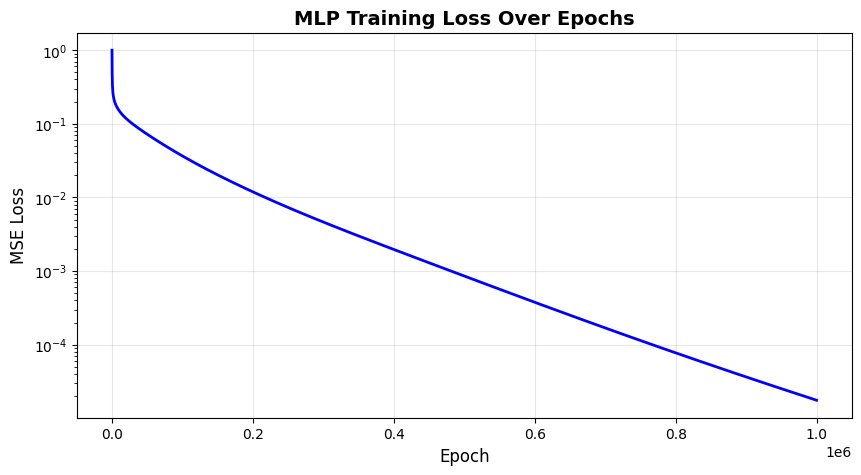

Initial Loss: 0.997346
Final Loss: 0.000018
Loss Reduction: 100.00%


In [139]:
# Plot 1: Training Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(model.losses, linewidth=2, color='blue')
plt.title('MLP Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to better see convergence
plt.show()

print(f"Initial Loss: {model.losses[0]:.6f}")
print(f"Final Loss: {model.losses[-1]:.6f}")
print(f"Loss Reduction: {((model.losses[0] - model.losses[-1]) / model.losses[0] * 100):.2f}%")

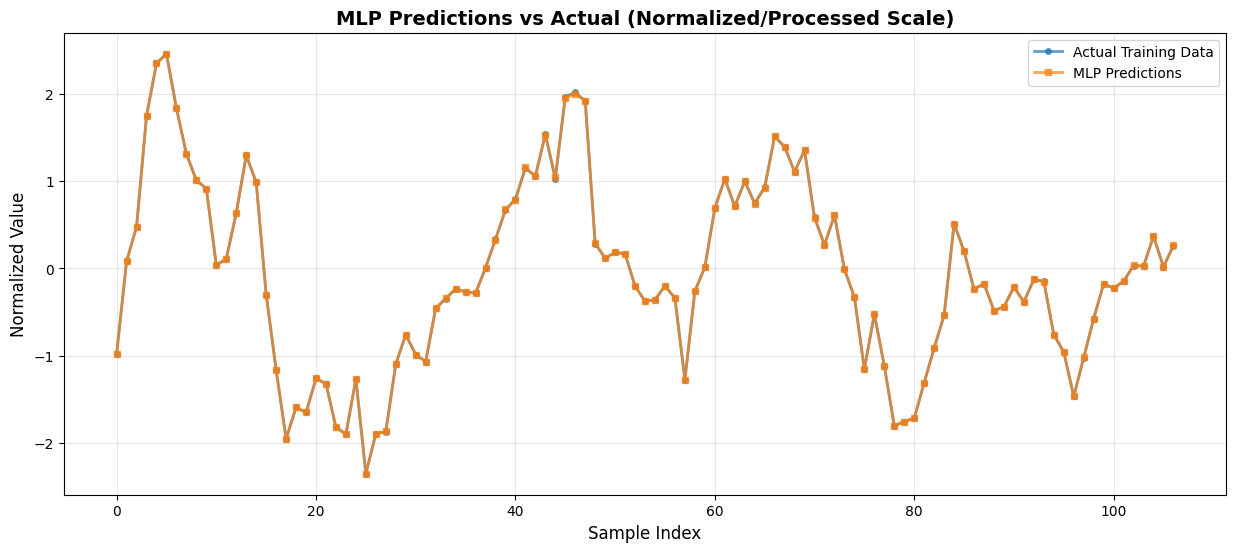

Training MSE: 0.000018
Training MAE: 0.002122


In [140]:
# Plot 2: Predictions vs Actual on Training Data (Processed Scale)
plt.figure(figsize=(15, 6))
plt.plot(y_train, label='Actual Training Data', linewidth=2, marker='o', markersize=4, alpha=0.7)
plt.plot(predictions_scaled, label='MLP Predictions', linewidth=2, marker='s', markersize=4, alpha=0.7)
plt.title('MLP Predictions vs Actual (Normalized/Processed Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate training metrics
train_mse = np.mean((predictions_scaled - y_train) ** 2)
train_mae = np.mean(np.abs(predictions_scaled - y_train))
print(f"Training MSE: {train_mse:.6f}")
print(f"Training MAE: {train_mae:.6f}")

In [141]:
# Make predictions for validation period (iterative forecasting)
def forecast_multiple_steps(model, last_sequence, n_steps=12):
    """
    Forecast multiple future time steps iteratively.
    Each prediction becomes part of the input for the next prediction.
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        # Predict next value
        next_value = model.predict(current_sequence.reshape(1, -1))[0]
        predictions.append(next_value)
        
        # Update sequence: remove oldest, add newest prediction
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_value
    
    return np.array(predictions)

# Get last 12 values from training data to start forecasting
last_sequence = training_data[-12:]
print(f"Last training sequence shape: {last_sequence.shape}")

# Forecast next 12 months
validation_predictions_scaled = forecast_multiple_steps(model, last_sequence, n_steps=12)

print(f"\nValidation predictions shape: {validation_predictions_scaled.shape}")
print(f"Validation data shape: {validation_data.shape}")

Last training sequence shape: (12,)

Validation predictions shape: (12,)
Validation data shape: (12,)


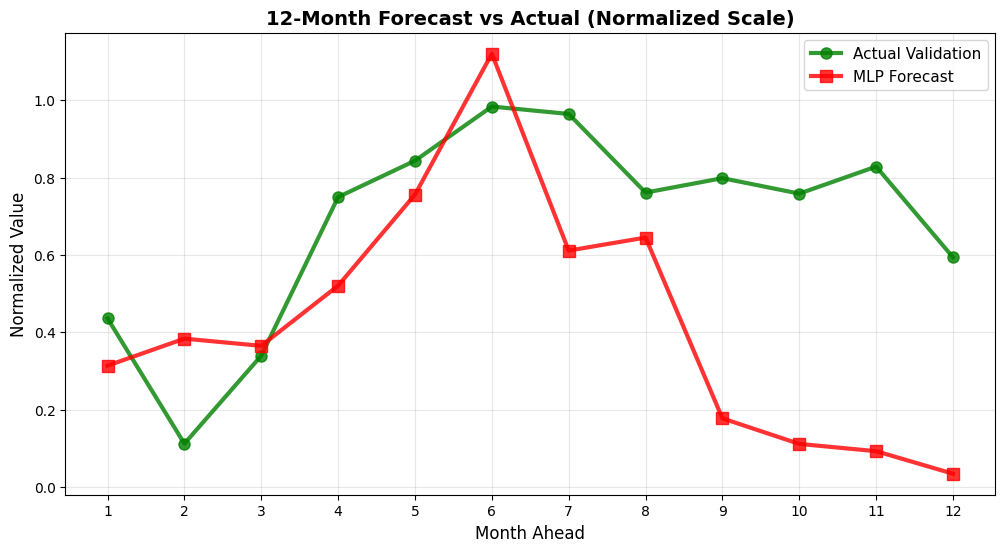


Validation Metrics (Normalized Scale):
MSE: 0.163850
MAE: 0.325501
RMSE: 0.404784


In [142]:
# Plot 3: Validation Predictions vs Actual (Processed Scale)
plt.figure(figsize=(12, 6))
months = np.arange(1, 13)
plt.plot(months, validation_data, 'o-', label='Actual Validation', 
         linewidth=3, markersize=8, color='green', alpha=0.8)
plt.plot(months, validation_predictions_scaled, 's-', label='MLP Forecast', 
         linewidth=3, markersize=8, color='red', alpha=0.8)
plt.title('12-Month Forecast vs Actual (Normalized Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Month Ahead', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(months)
plt.show()

# Validation metrics
val_mse = np.mean((validation_predictions_scaled - validation_data) ** 2)
val_mae = np.mean(np.abs(validation_predictions_scaled - validation_data))
val_rmse = np.sqrt(val_mse)
print(f"\nValidation Metrics (Normalized Scale):")
print(f"MSE: {val_mse:.6f}")
print(f"MAE: {val_mae:.6f}")
print(f"RMSE: {val_rmse:.6f}")

In [143]:
# Reverse transformations: Convert predictions back to original scale
print("="*60)
print("REVERSING TRANSFORMATIONS")
print("="*60)

# Step 1: Denormalize predictions
validation_predictions_denorm = scaler.inverse_transform(
    validation_predictions_scaled.reshape(-1, 1)
).flatten()

validation_actual_denorm = scaler.inverse_transform(
    validation_data.reshape(-1, 1)
).flatten()

print("\nStep 1 - Denormalized:")
print(f"Predictions: {validation_predictions_denorm[:3]}...")
print(f"Actual: {validation_actual_denorm[:3]}...")

# Step 2: Reverse seasonal differencing
# We need the detrended values from 12 months before the validation period
reference_values = de_trended[-(24):-12]

# Add back the seasonal component
validation_predictions_deseasoned = validation_predictions_denorm + reference_values
validation_actual_deseasoned = validation_actual_denorm + reference_values

print("\nStep 2 - Reverse seasonal differencing:")
print(f"Predictions: {validation_predictions_deseasoned[:3]}...")
print(f"Actual: {validation_actual_deseasoned[:3]}...")

# Step 3: Add back polynomial trend
# Get trend values for the validation period (last 12 points)
validation_trend = poly_trend[-12:]

validation_predictions_original = validation_predictions_deseasoned + validation_trend
validation_actual_original = validation_actual_deseasoned + validation_trend

print("\nStep 3 - Add back trend:")
print(f"Predictions: {validation_predictions_original[:3]}...")
print(f"Actual: {validation_actual_original[:3]}...")
print(f"\nOriginal validation values from series:")
print(f"Series: {y[-12:][:3]}...")
print("="*60)

REVERSING TRANSFORMATIONS

Step 1 - Denormalized:
Predictions: [155.36768617 186.99694541 178.56384889]...
Actual: [210.68400419  63.97354677 167.06308936]...

Step 2 - Reverse seasonal differencing:
Predictions: [ 59.40806296  85.82411554 -35.10639243]...
Actual: [114.72438099 -37.19928309 -46.60715197]...

Step 3 - Add back trend:
Predictions: [3764.68368197 3723.12339863 3533.60075953]...
Actual: [3820.  3600.1 3522.1]...

Original validation values from series:
Series: [3820.  3600.1 3522.1]...


In [144]:
# Calculate metrics on original scale
original_mse = np.mean((validation_predictions_original - y[-12:]) ** 2)
original_mae = np.mean(np.abs(validation_predictions_original - y[-12:]))
original_rmse = np.sqrt(original_mse)
original_mape = np.mean(np.abs((y[-12:] - validation_predictions_original) / y[-12:])) * 100

print("="*60)
print("FINAL METRICS ON ORIGINAL SCALE")
print("="*60)
print(f"MSE:  {original_mse:.2f}")
print(f"MAE:  {original_mae:.2f}")
print(f"RMSE: {original_rmse:.2f}")
print(f"MAPE: {original_mape:.2f}%")
print("="*60)

# Month-by-month comparison
comparison_df = pd.DataFrame({
    'Month': range(1, 13),
    'Actual': y[-12:],
    'Predicted': validation_predictions_original,
    'Error': validation_predictions_original - y[-12:],
    'Abs_Error': np.abs(validation_predictions_original - y[-12:]),
    'Pct_Error': ((validation_predictions_original - y[-12:]) / y[-12:]) * 100
})

print("\nMonth-by-Month Comparison:")
print(comparison_df.to_string(index=False))

FINAL METRICS ON ORIGINAL SCALE
MSE:  33624.93
MAE:  147.46
RMSE: 183.37
MAPE: 4.40%

Month-by-Month Comparison:
 Month  Actual   Predicted       Error  Abs_Error  Pct_Error
     1  3820.0 3764.683682  -55.316318  55.316318  -1.448071
     2  3600.1 3723.123399  123.023399 123.023399   3.417222
     3  3522.1 3533.600760   11.500760  11.500760   0.326531
     4  3493.9 3390.132685 -103.767315 103.767315  -2.969957
     5  3531.7 3492.005590  -39.694410  39.694410  -1.123946
     6  3492.7 3554.549218   61.849218  61.849218   1.770814
     7  3414.9 3254.832299 -160.067701 160.067701  -4.687332
     8  3312.0 3259.316674  -52.683326  52.683326  -1.590680
     9  3257.2 2975.799443 -281.400557 281.400557  -8.639339
    10  3304.1 3010.887182 -293.212818 293.212818  -8.874211
    11  3306.9 2973.465154 -333.434846 333.434846 -10.083004
    12  3199.7 2946.189543 -253.510457 253.510457  -7.922945


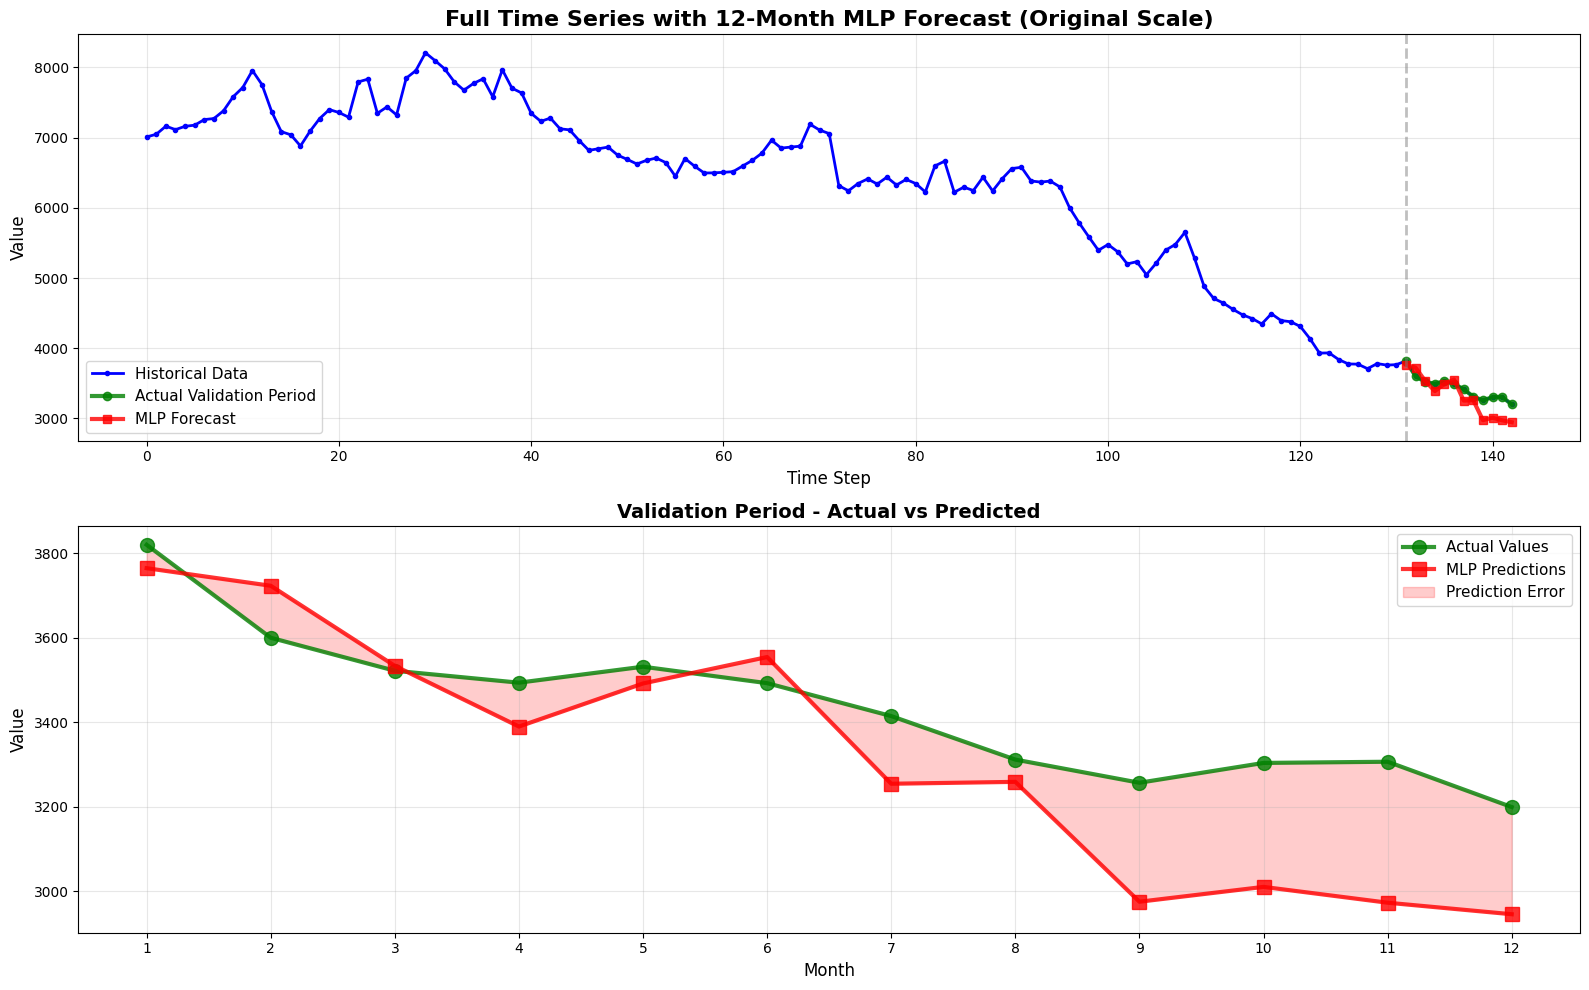

In [145]:
# Plot 4: Full Time Series with Forecast (Original Scale)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Top plot: Full series
ax1.plot(range(len(y)), y, 'b-', linewidth=2, label='Historical Data', marker='o', markersize=3)
ax1.plot(range(len(y) - 12, len(y)), y[-12:], 'go-', linewidth=3, 
         markersize=6, label='Actual Validation Period', alpha=0.8)
ax1.plot(range(len(y) - 12, len(y)), validation_predictions_original, 'rs-', 
         linewidth=3, markersize=6, label='MLP Forecast', alpha=0.8)
ax1.axvline(len(y) - 12, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax1.set_title('Full Time Series with 12-Month MLP Forecast (Original Scale)', 
              fontsize=16, fontweight='bold')
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom plot: Zoomed validation period
months = np.arange(1, 13)
ax2.plot(months, y[-12:], 'go-', linewidth=3, markersize=10, 
         label='Actual Values', alpha=0.8)
ax2.plot(months, validation_predictions_original, 'rs-', linewidth=3, 
         markersize=10, label='MLP Predictions', alpha=0.8)
ax2.fill_between(months, y[-12:], validation_predictions_original, 
                  alpha=0.2, color='red', label='Prediction Error')
ax2.set_title('Validation Period - Actual vs Predicted', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(months)

plt.tight_layout()
plt.show()

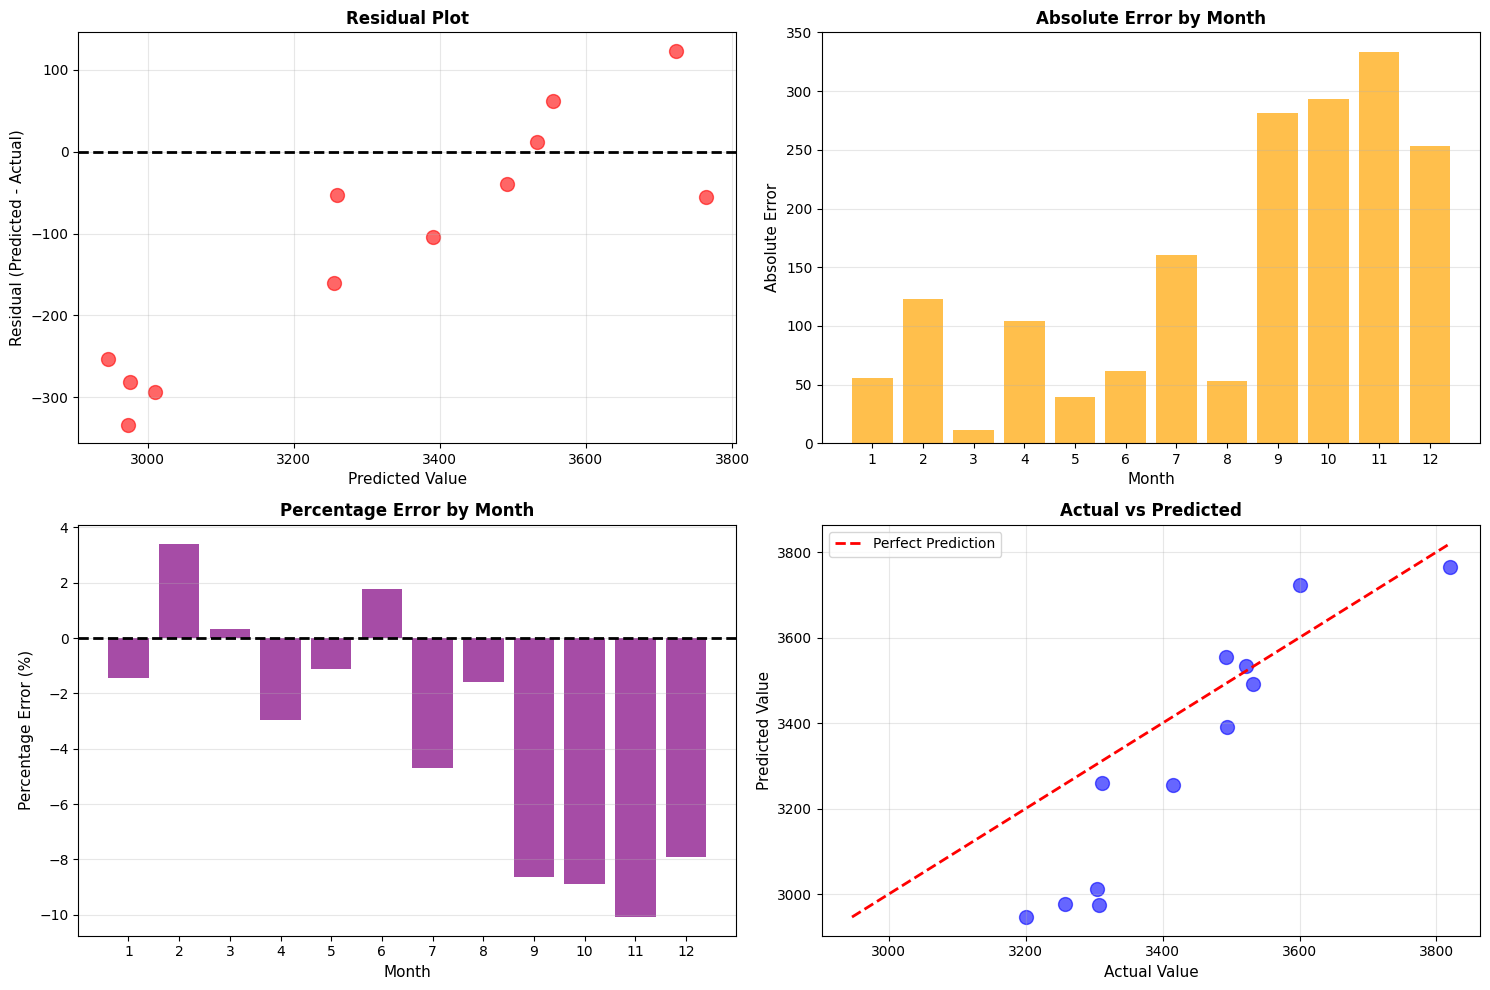

In [146]:
# Plot 5: Error Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Residual plot
axes[0, 0].scatter(validation_predictions_original, 
                   validation_predictions_original - y[-12:], 
                   s=100, alpha=0.6, color='red')
axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Value', fontsize=11)
axes[0, 0].set_ylabel('Residual (Predicted - Actual)', fontsize=11)
axes[0, 0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Absolute error by month
axes[0, 1].bar(months, np.abs(validation_predictions_original - y[-12:]), 
               color='orange', alpha=0.7)
axes[0, 1].set_xlabel('Month', fontsize=11)
axes[0, 1].set_ylabel('Absolute Error', fontsize=11)
axes[0, 1].set_title('Absolute Error by Month', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(months)

# 3. Percentage error by month
axes[1, 0].bar(months, comparison_df['Pct_Error'], color='purple', alpha=0.7)
axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Month', fontsize=11)
axes[1, 0].set_ylabel('Percentage Error (%)', fontsize=11)
axes[1, 0].set_title('Percentage Error by Month', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticks(months)

# 4. Actual vs Predicted scatter
axes[1, 1].scatter(y[-12:], validation_predictions_original, s=100, alpha=0.6, color='blue')
# Perfect prediction line
min_val = min(y[-12:].min(), validation_predictions_original.min())
max_val = max(y[-12:].max(), validation_predictions_original.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Value', fontsize=11)
axes[1, 1].set_ylabel('Predicted Value', fontsize=11)
axes[1, 1].set_title('Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()